# Setup

In [2]:
using Plots
using FFTW
using BenchmarkTools

include("../spinning_compass_functions.jl")

Main.Phase_diagram

# Functions

In [2]:
function hooke(r, t, k)
    (x, v) = r
    dxdt = v
    dvdt = -k*x
    return [dxdt, dvdt]
end


"""
    RK4(eom_func, t_param, r)

Solve systems of first-order ordinary differential equations using the fourth-order Runge-Kutta method.

# Args
- eom_func (Function): function corresponding to the equations of motion to be integrated. The function must follow the format: `eom_func(r, t)`.

- time_param (Tuple): initial and final time, and number of steps of the integration. `time_param` must follow the format: `time_param = [t_initial, t_final, Npoints]`

- r (Array): initial state of the system. r must follow the same ordering of variables used in `eom_func`.

# Returns
- (tpoints, rpoints): Arrays containing the IVP solution of the EOM

# Notes
- Each row in rpoints contains the values of a particular dependent variable. To unpack these values, one may do
```
    xpoints, ypoints = eachrow(rpoints)  # returned objects are SubArray not Array

    OR

    xpoints = rpoints[1, :]
    ypoints = rpoints[2, :]
```
"""
function RK4(eom_func::Function, t_param::Tuple{Float64, Float64, Int64}, r::Vector{Float64})

    # Initialize time array
    (t_initial, t_final, Npoints) = t_param
    h = abs(t_final - t_initial) / Npoints
    tpoints = range(t_initial, t_final, Npoints)

    # Initialize trajectory array
    rpoints = zeros(length(r), Npoints)

    # Runge-Kutta algorithm
    for (i, t) in enumerate(tpoints)
        rpoints[:, i] = r
        k1 = h*eom_func(r, t)
        k2 = h*eom_func(r .+ (0.5 .* k1), t + 0.5*h)
        k3 = h*eom_func(r .+ (0.5 .* k2), t + 0.5*h)
        k4 = h*eom_func(r .+ k3, t + h)
        r = r .+ (k1 + 2 .* k2 + 2 .* k3 + k4) / 6
    end
    return tpoints, rpoints
end

RK4

In [121]:
function spectral_entropy_old(observable::Array)
    fourier_observable = fftshift(fft(observable))
    power_spectrum = abs.(fourier_observable).^2 
    normalized_power = power_spectrum./ sum(power_spectrum)

    #calculating spectral entropy
    H_spectral = 0
    @simd for probability in normalized_power
        if probability >= 1e-10
            H_spectral += probability * log2(probability)
        else
            H_spectral += 0
        end
    end
    H_spectral /= -1 * log2( length(normalized_power))
    return H_spectral
end

spectral_entropy_old (generic function with 1 method)

In [122]:
"""
    spectral_entropy(observable)

# Description
Calculates the spectral entropy of a single observable. Note that the function has a dependency on the FFTW package
as it uses the fft function to do a fast fourier transform.
"""
function spectral_entropy_new(x, cutoff::Float64 = 1e-10)
    fourier_x = fftshift(fft(x))
    power_spectrum = abs2.(fourier_x)  # abs2 slightly faster than abs()^2
    power_spectrum ./= sum(power_spectrum)  # normalization

    spectral = filter(x -> x > cutoff, power_spectrum)  # remove items below cutoff
    spectral .*= log2.(spectral)
    spectral /= -1 * log2(length(power_spectrum))

    return sum(spectral)
end

spectral_entropy_new (generic function with 2 methods)

---

# Prototype 1

In [93]:
# Function parameters
k = 1.0
f(r, t) = hooke(r, t, k)

# Simulation parameters
Npoints = 1001
t_initial, t_final = 0.0, 10 * (2*π) / k^0.5
time_param = (t_initial, t_final, Npoints)

sampling_rate = Npoints / abs(t_final - t_initial)

# Initial conditions
x0, v0 = 1.0, 0.0
r = [x0, v0]

2-element Vector{Float64}:
 1.0
 0.0

In [94]:
tpoints, rpoints = RK4(f, time_param, r)
xpoints, vpoints = eachrow(rpoints)

2-element RowSlices{Matrix{Float64}, Tuple{Base.OneTo{Int64}}, SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}}:
 [1.0, 0.9980306678505112, 0.9921304287893151, 0.9823225218756855, 0.9686455771574211, 0.9511534635200756, 0.9299150765155338, 0.9050140670056069, 0.8765485116894278, 0.8446305268123291  …  0.8093807228273552, 0.844625829137592, 0.8765442385358071, 0.905010235152348, 0.9299117010097064, 0.9511505576174866, 0.9686431522705585, 0.9823205875288985, 0.9921289925814047, 0.9980297354248797]
 [0.0, -0.06272786606303697, -0.1252086681194604, -0.1871963153180977, -0.2484466591789986, -0.30871845521212815, -0.3677743130982194, -0.42538163168934406, -0.4813135151465483, -0.5353496666061955  …  0.5872835806634433, 0.5353562986516576, 0.4813204283977671, 0.4253887990107168, 0.3677817063564785, 0.30872604538676907, 0.24845441647619174, 0.18720420928763717, 0.12521666777429086, 0.06273594000088895]

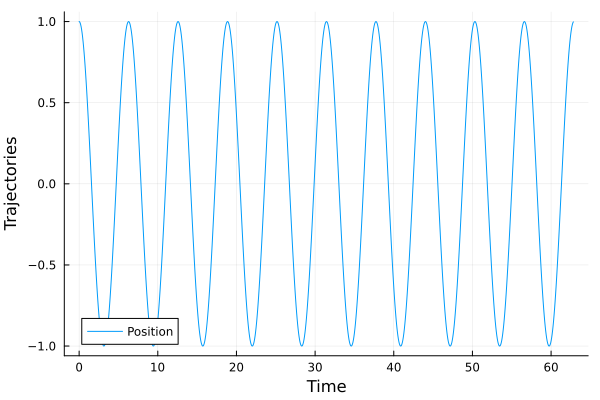

In [95]:
plot(tpoints, xpoints, label="Position")
xlabel!(raw"Time")
ylabel!(raw"Trajectories")

In [96]:
fourier_xpoints = fftshift(fft(xpoints))
fourier_freq = 2π .* fftshift(fftfreq(Npoints, sampling_rate))

power_xpoints = abs2.(fourier_xpoints)
power_total = sum(power_xpoints)
normalized_power = power_xpoints ./ power_total

1001-element Vector{Float64}:
 2.305997172950386e-19
 2.3060490366550935e-19
 2.3061528723691044e-19
 2.306308460572142e-19
 2.306516068559625e-19
 2.3067755878051306e-19
 2.3070870052563737e-19
 2.3074503802016556e-19
 2.3078659222504545e-19
 2.3083333491599e-19
 2.308853054850954e-19
 2.3094247697981444e-19
 2.3100486921289015e-19
 ⋮
 2.3094247697982407e-19
 2.3088530548510193e-19
 2.308333368414489e-19
 2.307865922250505e-19
 2.3074503802016546e-19
 2.307087005256373e-19
 2.306775587805112e-19
 2.3065160685596564e-19
 2.306308622671156e-19
 2.3061528723690794e-19
 2.306049036655075e-19
 2.305997172950428e-19

In [97]:
threshold = 1e-5
spectral_entropy = normalized_power[normalized_power .> threshold]
spectral_entropy = spectral_entropy .* log2.(spectral_entropy)
spectral_entropy /= -1 * log2(length(normalized_power))
sum(spectral_entropy)

0.10032881506185601

In [123]:
spectral_entropy_new(xpoints)

0.10032881506185601

In [124]:
spectral_entropy_old(rpoints[1, :])

0.10032881506185602

# Benchmarks

In [127]:
@benchmark spectral_entropy_new(rpoints[1, :], 1e-10)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  25.500 μs …  66.155 ms  ┊ GC (min … max): 0.00% … 77.07%
 Time  (median):     33.100 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   54.926 μs ± 662.482 μs  ┊ GC (mean ± σ):  9.28% ±  0.77%

  ██▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁  ▁                                 ▂
  ██████████████████████████████▇█▇▇▇▇▅▆▅▅▅▆▅▅▄▄▅▄▅▅▄▅▄▄▅▄▄▄▄▅ █
  25.5 μs       Histogram: log(frequency) by time       205 μs <

 Memory estimate: 71.84 KiB, allocs estimate: 13.

In [128]:
@benchmark spectral_entropy_old(rpoints[1, :])

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  31.700 μs …  65.335 ms  ┊ GC (min … max): 0.00% … 77.59%
 Time  (median):     41.400 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   61.923 μs ± 653.767 μs  ┊ GC (mean ± σ):  8.19% ±  0.78%

  ▅█▆▆▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁                                   ▂
  ███████████████████████████████████▆▇▅▇▇▆▆▆▆▆▆▅▅▄▅▄▅▄▆▄▅▅▄▆▄ █
  31.7 μs       Histogram: log(frequency) by time       199 μs <

 Memory estimate: 71.77 KiB, allocs estimate: 12.

In [102]:
@code_warntype spectral_entropy_new(xpoints, 1e-10)

MethodInstance for spectral_entropy_new(::SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}, ::Float64)
  from spectral_entropy_new(x, cutoff) @ Main In[87]:1
Arguments
  #self#::Core.Const(spectral_entropy_new)
  x::SubArray{Float64, 1, Matrix{Float64}, Tuple{Int64, Base.Slice{Base.OneTo{Int64}}}, true}
  cutoff::Float64
Locals
  #1::var"#1#2"{Float64}
  spectral::Vector{Float64}
  normalized_power::Vector{Float64}
  power_spectrum::Vector{Float64}
  fourier_x::Vector{ComplexF64}
Body::Float64
1 ─ %1  = Main.fft(x)::Vector{ComplexF64}
│         (fourier_x = Main.fftshift(%1))
│   %3  = Base.broadcasted(Main.abs2, fourier_x)::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(abs2), Tuple{Vector{ComplexF64}}}
│         (power_spectrum = Base.materialize(%3))
│   %5  = Main.:/::Core.Const(/)
│   %6  = power_spectrum::Vector{Float64}
│   %7  = Main.sum(power_spectrum)::Float64
│   %8  = Base.broadcasted(%5, %6, %7)::Base

# Scratchpad

In [10]:
x = [1, 2, 3]
x[[true, false, true]]

2-element Vector{Int64}:
 1
 3

In [32]:
x = [1, 2, 3]
x[x .> 1]

2-element Vector{Int64}:
 2
 3